# Network Data Analysis

In [103]:
# imports and configuration
import json
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

####################################################
# BEGIN CUSTOMIZATION HERE
#
DATA_ROOT='data/20210226/'
RESULTS_ROOT='results/20210226/'
RUNS_PER_CONFIG=10

# provide an entry for each of the wireless locations
# loc is the friendly name of the location, eg. 'kitchen', 'masterbr'
# prefix is the data capture results prefix (unique capture id) you used
# when capturing the data
WIRELESS_LOCATIONS=[{'loc': 'L06', 'prefix': 'loc06'},
                    {'loc': 'L07', 'prefix': 'loc07'},
                    {'loc': 'L08', 'prefix': 'loc08'},
                    {'loc': 'L09', 'prefix': 'loc09'},
                    {'loc': 'L10', 'prefix': 'loc10'}]

# provide an entry for each of the wireless networks you captured
# ssid is the network id you want displayed
# id is the key used in the data files you used when capturing the data
WIRELESS_NETWORKS=[{'ssid': 'SSID1', 'id': 'w1'},
                   {'ssid': 'SSID2', 'id': 'w2'},
                   {'ssid': 'SSID3', 'id': 'w3'},
                   {'ssid': 'SSID4', 'id': 'w4'}]

# provide an entry for each of the wired locations
# loc is the friendly name of the location, eg. 'kitchen', 'masterbr'
# prefix is the data capture results prefix (unique capture id) you used
# when capturing the data
WIRED_LOCATIONS=[{'loc': 'L01', 'prefix': 'loc01'},
                 {'loc': 'L02', 'prefix': 'loc02'},
                 {'loc': 'L03', 'prefix': 'loc03'},
                 {'loc': 'L04', 'prefix': 'loc04'},
                 {'loc': 'L05', 'prefix': 'loc05'}]

#
# END CUSTOMIZATION HERE
####################################################

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

sns.set_theme(style="whitegrid")
os.makedirs(RESULTS_ROOT, exist_ok=True)

In [104]:
WIRELESS_LOC_LABELS = [x['loc'] for x in WIRELESS_LOCATIONS]
WIRED_LOC_LABELS = [x['loc'] for x in WIRED_LOCATIONS]
SSID_LABLES = [x['ssid'] for x in WIRELESS_NETWORKS]

In [105]:
def get_iperf_results(data, location, ssid, reverse):
    results = {
        'location': location,
        'ssid': ssid,
        'sent': data['end']['sum_sent']['bits_per_second']/10**6,
        'recv': data['end']['sum_received']['bits_per_second']/10**6,
        'rexmit': data['end']['sum_sent']['retransmits']
    }
    if reverse:
        results['dir'] = 'sc'
    else:
        results['dir'] = 'cs'
    return results

def load_loc_ssid_data(df, loc, ssid, stub):
    for x in range(RUNS_PER_CONFIG):
        
        # forward c --> s
        fname = os.path.join(DATA_ROOT, "{0}{1:02d}.f.json".format(stub, x+1))
        with open(fname) as json_file:
            data = json.load(json_file)
        df = df.append(get_iperf_results(data, loc, ssid, False), ignore_index=True)

        # reverse s --> c
        rname = os.path.join(DATA_ROOT, "{0}{1:02d}.r.json".format(stub, x+1))
        with open(rname) as json_file:
            data = json.load(json_file)
        df = df.append(get_iperf_results(data, loc, ssid, True), ignore_index=True)
    return df

def load_location_data(df, loc, prefix):
    for network in WIRELESS_NETWORKS:
        df = load_loc_ssid_data(df, loc, network['ssid'], '{}.{}.'.format(prefix, network['id']))
    return df

In [106]:
variables = {'location':'',
             'ssid': '',
             'sent':float(),
             'recv':float(),
             'rexmit':int(),
             'dir':''}
df = pd.DataFrame(variables, index=[])

In [107]:
for entry in WIRELESS_LOCATIONS:
    df = load_location_data(df, entry['loc'], entry['prefix'])

In [108]:
df2 = pd.DataFrame(variables, index=[])

In [109]:
for entry in WIRED_LOCATIONS:
    df2 = load_loc_ssid_data(df2, entry['loc'], 'wired', '{}.'.format(entry['prefix']))    

In [112]:
df2

,location,ssid,sent,recv,rexmit,dir
0,L01,wired,938.169947,938.159297,0,cs
1,L01,wired,454.568763,453.863305,2891,sc
2,L01,wired,904.765966,904.264163,0,cs
3,L01,wired,537.535736,536.650730,2065,sc
4,L01,wired,935.980795,935.425704,0,cs
...,...,...,...,...,...,...
95,L05,wired,746.334815,744.098989,1442,sc
96,L05,wired,938.293922,938.292316,0,cs
97,L05,wired,579.260410,577.501969,2739,sc
98,L05,wired,938.698538,938.226851,0,cs


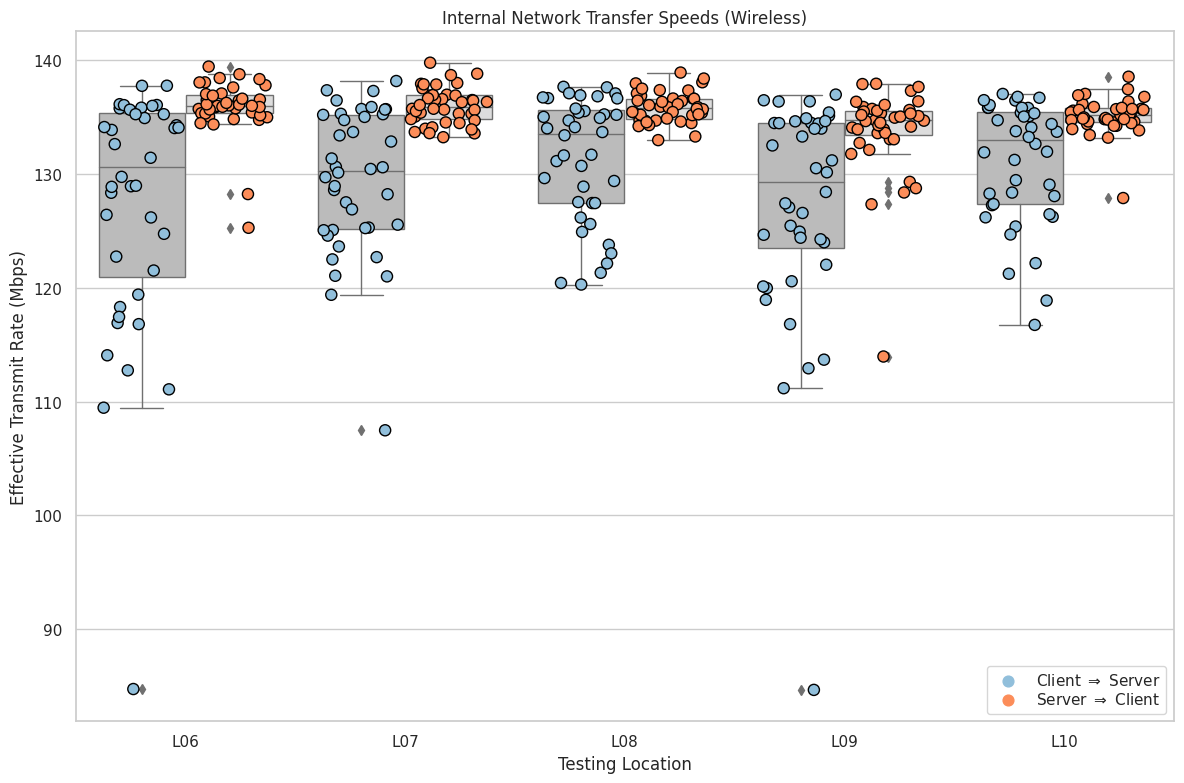

In [113]:
params = dict(data=df,
              x='location',
              y='recv',
              hue='dir',
              dodge=True)
ax = sns.stripplot(size=8,
                  jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  linewidth=1,
                  **params)
p_box = sns.boxplot(palette=['#BBBBBB','#DDDDDD'],linewidth=1,**params)

ax.set(xlabel='Testing Location', ylabel='Effective Transmit Rate (Mbps)', title="Internal Network Transfer Speeds (Wireless)")
ax.set_xticklabels(WIRELESS_LOC_LABELS)
handles,labels = ax.get_legend_handles_labels()
plt.legend(handles[2:],
           ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
           frameon=True,
           labelspacing=0.2)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + '/internal_wireless.png')

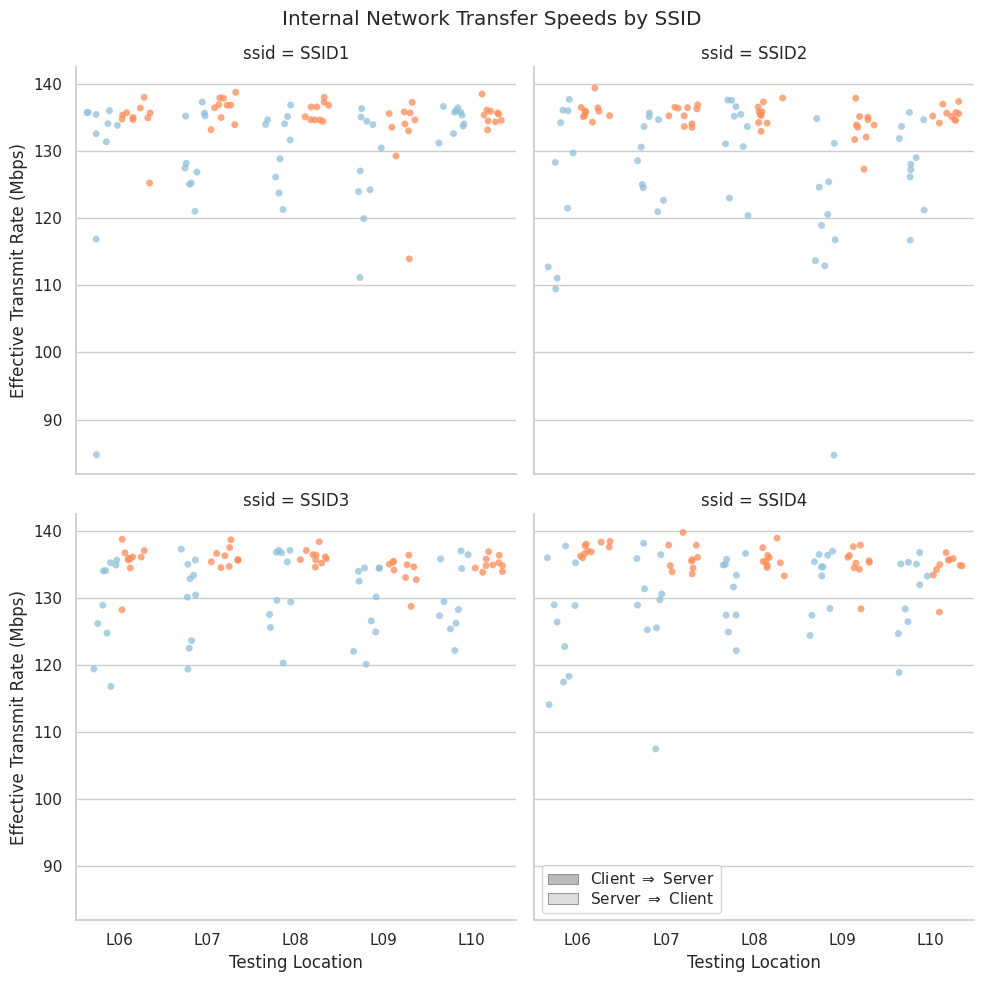

In [114]:
params = dict(data=df,
              x='location',
              y='recv',
              hue='dir',
              col='ssid',
              col_wrap=2,
              dodge=True)
p = sns.catplot(jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                alpha=0.75,
                legend=False,
                  **params)
p.set_xticklabels(WIRELESS_LOC_LABELS)
# use ax from prior
handles,labels = ax.get_legend_handles_labels()
plt.legend(handles,
           ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
           frameon=True,
           labelspacing=0.2)
p.fig.suptitle('Internal Network Transfer Speeds by SSID')
p.set_xlabels('Testing Location')
p.set_ylabels('Effective Transmit Rate (Mbps)')
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'internal_wireless_ssid.png')

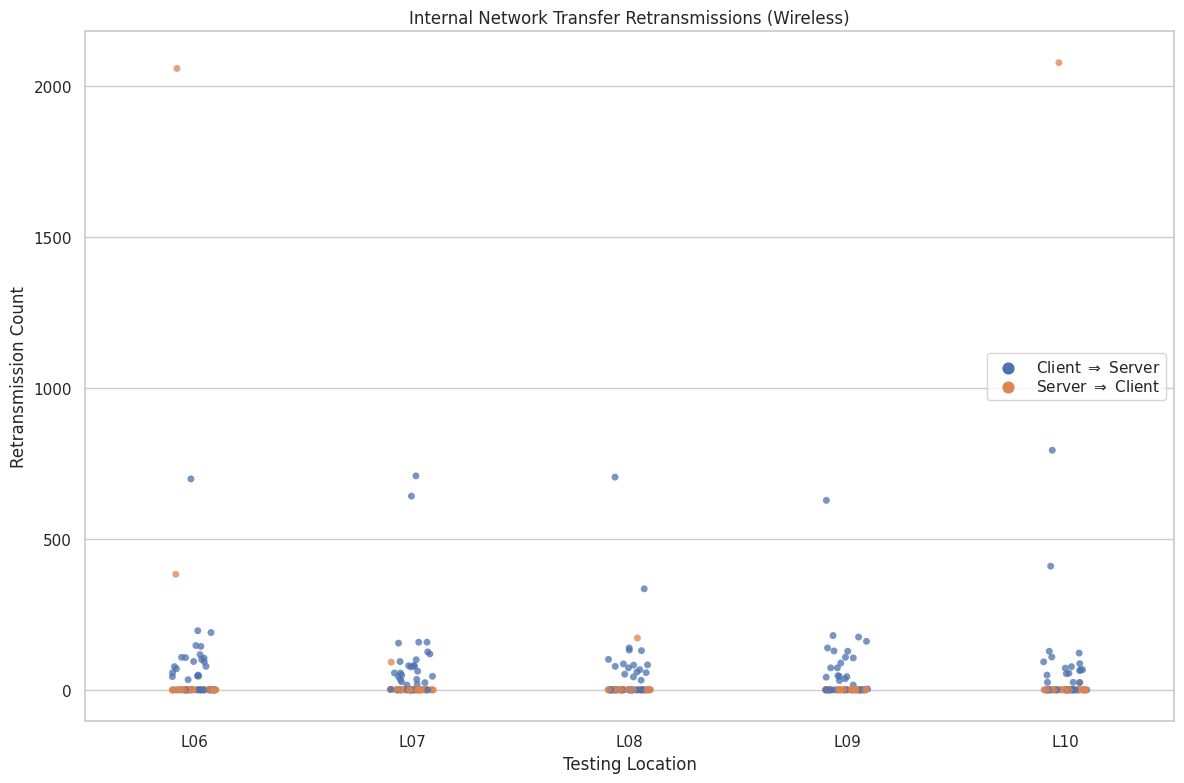

In [115]:
ax = sns.stripplot(y='rexmit', x='location', 
                   data=df, 
                   jitter=True,
                   marker='o', 
                   alpha=0.75, hue="dir")
handles,labels = ax.get_legend_handles_labels()
plt.legend(handles,
           ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
           frameon=True,
           labelspacing=0.2)
ax.set(xlabel='Testing Location', ylabel='Retransmission Count', title="Internal Network Transfer Retransmissions (Wireless)")
ax.set_xticklabels(WIRELESS_LOC_LABELS)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'internal_wireless_rexmit.png')

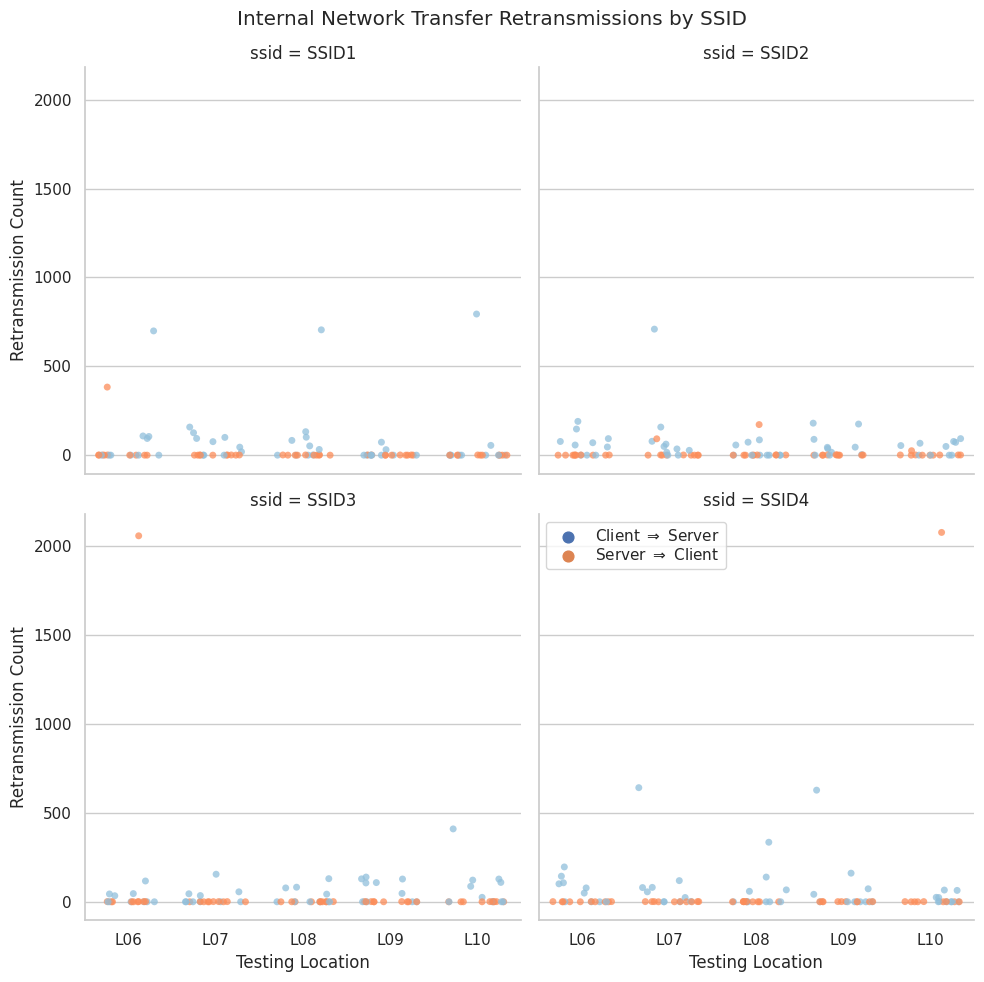

In [116]:
params = dict(data=df,
              x='location',
              y='rexmit',
              hue='dir',
              #jitter=0.25,
              col='ssid',
              dodge=False)
p = sns.catplot(jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  #linewidth=1,
                  col_wrap=2,
                   # marker='o',
                legend=False,
                alpha=0.75,
                  **params)
p.set_xticklabels(WIRELESS_LOC_LABELS)
p.fig.suptitle('Internal Network Transfer Retransmissions by SSID')
p.set_xlabels('Testing Location')
p.set_ylabels('Retransmission Count')
handles,labels = ax.get_legend_handles_labels()
plt.legend(handles,
           ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
           frameon=True,
           labelspacing=0.2)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'internal_wireless_rexmit_ssid.png')

## Wired Network Results

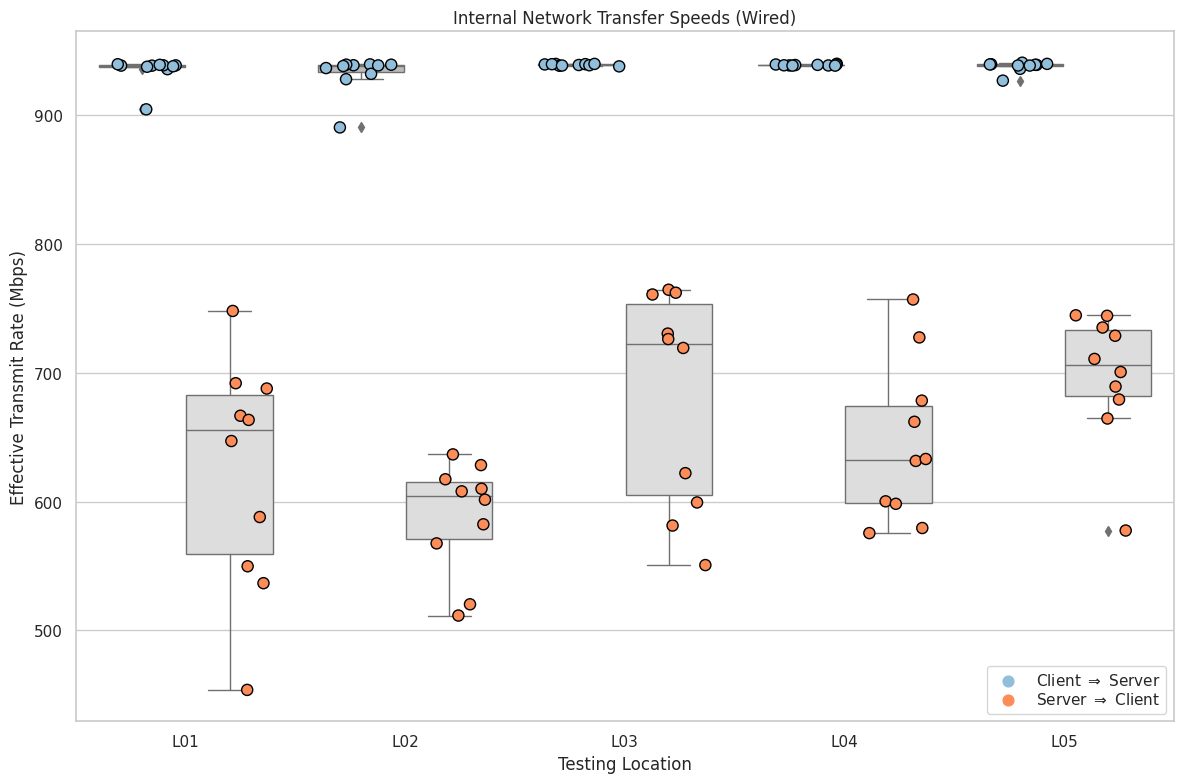

In [117]:
params = dict(data=df2,
              x='location',
              y='recv',
              hue='dir',
              #jitter=0.25,
              dodge=True)
p = sns.stripplot(size=8,
                  jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  linewidth=1,
                  **params)
p_box = sns.boxplot(palette=['#BBBBBB','#DDDDDD'],linewidth=1,**params)

p.set(xlabel='Testing Location', ylabel='Effective Transmit Rate (Mbps)', title="Internal Network Transfer Speeds (Wired)")
p.set_xticklabels(WIRED_LOC_LABELS)

handles,labels = p.get_legend_handles_labels()
plt.legend(handles[2:],
           ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
           frameon=True,
           labelspacing=0.2)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'internal_wired.png')

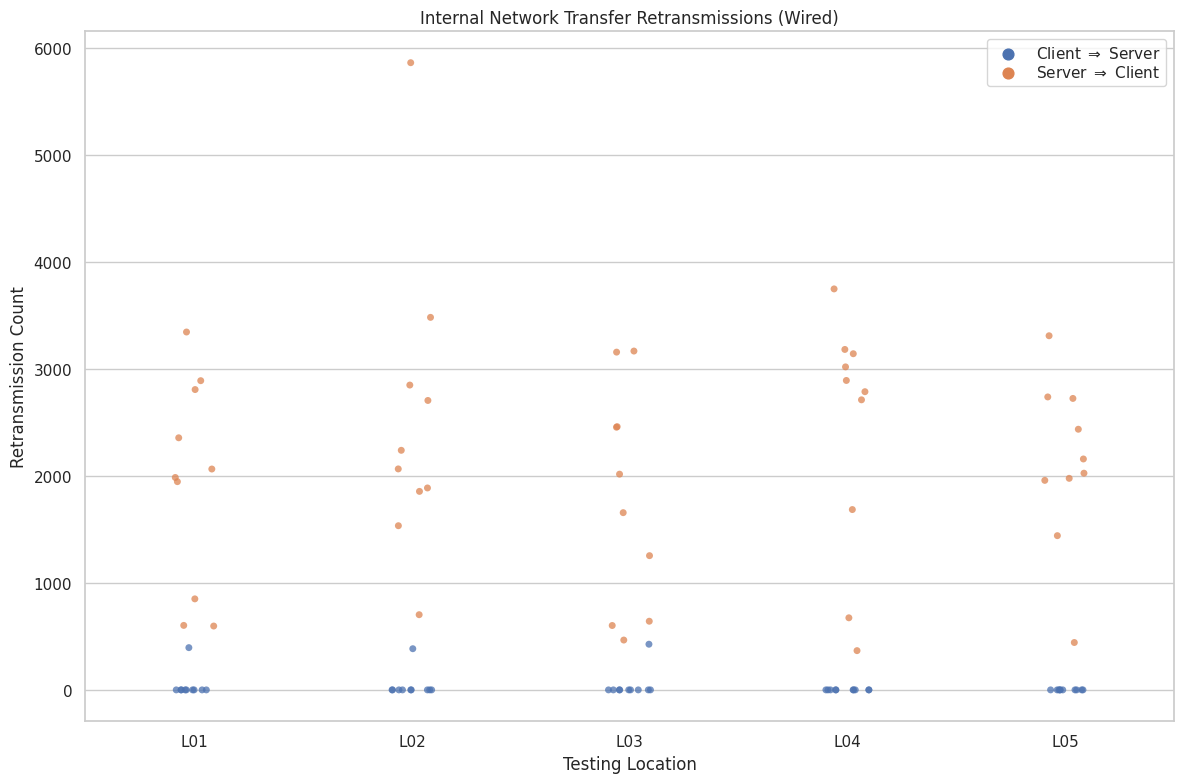

In [118]:
ax = sns.stripplot(y='rexmit', x='location', 
                   data=df2, 
                   jitter=True,
                   marker='o', 
                   alpha=0.75, hue="dir")
handles,labels = ax.get_legend_handles_labels()
plt.legend(handles,
           ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
           frameon=True,
           labelspacing=0.2)
ax.set(xlabel='Testing Location', ylabel='Retransmission Count', title="Internal Network Transfer Retransmissions (Wired)")
ax.set_xticklabels(WIRED_LOC_LABELS)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'internal_wired_rexmit.png')

In [119]:
# Now, we need to lump all the wireless stuff together, and compare it against the wired stuff.
# we know the end result, just need to document it.




In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  400 non-null    object 
 1   ssid      400 non-null    object 
 2   sent      400 non-null    float64
 3   recv      400 non-null    float64
 4   rexmit    400 non-null    int64  
 5   dir       400 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ KB


In [121]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  100 non-null    object 
 1   ssid      100 non-null    object 
 2   sent      100 non-null    float64
 3   recv      100 non-null    float64
 4   rexmit    100 non-null    int64  
 5   dir       100 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.8+ KB


In [122]:
dfm = df.append(df2)

In [123]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 99
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  500 non-null    object 
 1   ssid      500 non-null    object 
 2   sent      500 non-null    float64
 3   recv      500 non-null    float64
 4   rexmit    500 non-null    int64  
 5   dir       500 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 27.3+ KB


In [124]:
dfm.head()

,location,ssid,sent,recv,rexmit,dir
0,L06,SSID1,117.819680,116.891294,105,cs
1,L06,SSID1,137.816773,135.679333,0,sc
2,L06,SSID1,134.431724,133.838191,0,cs
3,L06,SSID1,136.703174,134.721697,1,sc
4,L06,SSID1,135.731673,135.729312,0,cs


In [125]:
dfm['is_wired'] = np.where(dfm['ssid']== 'wired', True, False)

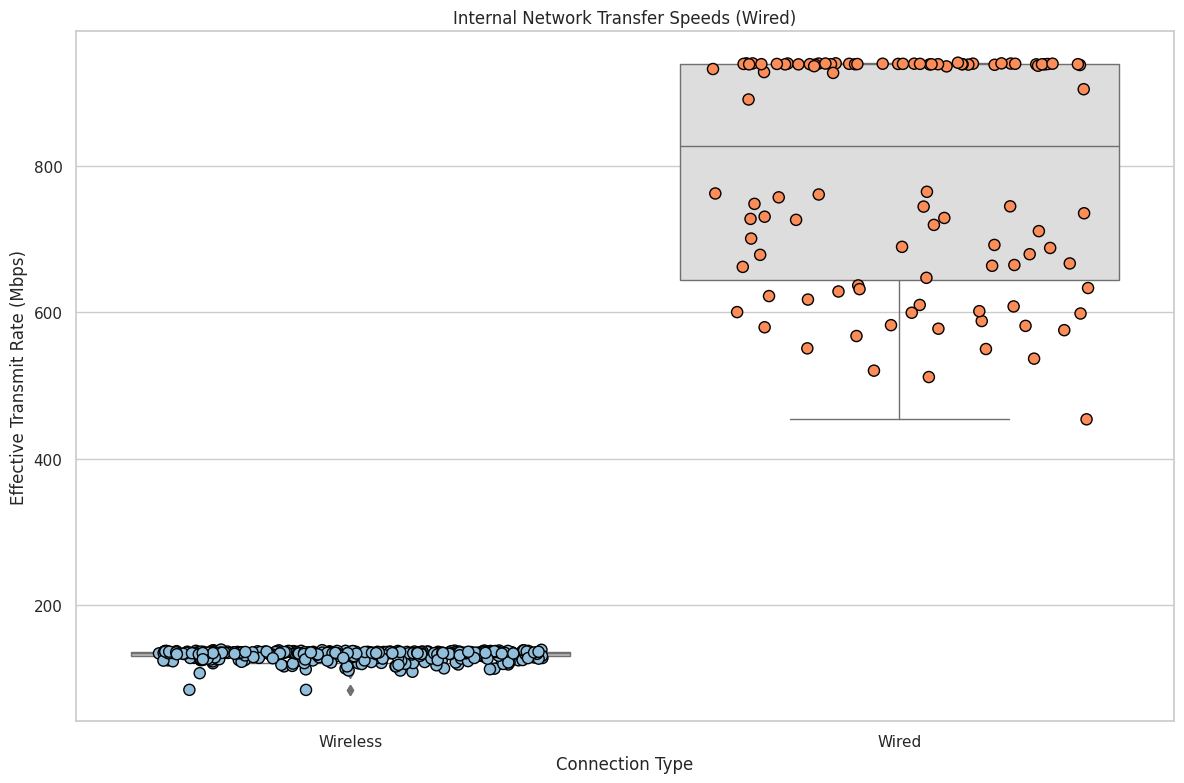

In [126]:
params = dict(data=dfm,
              x='is_wired',
              y='recv',
#              hue='dir',
              #jitter=0.25,
              dodge=True)
p = sns.stripplot(size=8,
                  jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  linewidth=1,
                  **params)
p_box = sns.boxplot(palette=['#BBBBBB','#DDDDDD'],linewidth=1,**params)

p.set(xlabel='Connection Type', ylabel='Effective Transmit Rate (Mbps)', title="Internal Network Transfer Speeds (Wired)")
p.set_xticklabels(['Wireless','Wired'])
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'internal_wired_vs_wireless.png')

In [127]:
# let's get some values
dfm.groupby("is_wired").recv.describe().unstack()

       is_wired
count  False       400.000000
       True        100.000000
mean   False       132.243927
       True        791.596440
std    False         6.708554
       True        155.107000
min    False        84.694004
       True        453.863305
25%    False       130.337366
       True        644.347382
50%    False       134.786804
       True        827.276987
75%    False       135.952974
       True        938.415821
max    False       139.738491
       True        940.458537
dtype: float64

## Speed Test Results

In [68]:
#fname = os.path.join(DATA_ROOT, "{0}{1}.json".format(stub, x+1))
fname = os.path.join(DATA_ROOT, "loc01_st_01.json")
with open(fname) as json_file:
    data = json.load(json_file)

latency = data["ping"]["latency"]
print("Ping Latency: {} ms".format(latency))

# bandwidth is listed in bits... need to divide by 125000 to get Mbps
# note: this seems odd, but the result matches what Ookla results page shows
dlbw = data['download']['bandwidth']/125000
print(dlbw)

dlbytes = data['download']['bytes']
print(dlbytes)
print(dlbytes*8)
dlelapse = data['download']['elapsed']
print(dlelapse)



Ping Latency: 11.419 ms
527.077248
643119560
5144956480
10615


In [89]:
# variables = {'location':'',
#              'ssid': '',
#              'latency':float(),
#              'download':float(),
#              'upload':int(),
#              'packetLoss':float()}
variables = {'location':'',
             'ssid': '',
             'latency':float(),
             'speed':float(),
             'dir':'',
             'packetLoss':float()}
df3 = pd.DataFrame(variables, index=[])
df4 = pd.DataFrame(variables, index=[])

In [90]:
def get_st_results(data, location, ssid):
    results = []
    results.append({
        'location': location,
        'ssid': ssid,
        'latency': data['ping']['latency'],
        'speed': data['download']['bandwidth']/125000,
        'dir': 'down',
        'packetLoss': data['packetLoss']
    })
    results.append({
        'location': location,
        'ssid': ssid,
        'latency': data['ping']['latency'],
        'speed': data['upload']['bandwidth']/125000,
        'dir': 'up',
        'packetLoss': data['packetLoss']
    })    

    return results

def load_loc_ssid_st_data(df, loc, ssid, stub):
    for x in range(RUNS_PER_CONFIG):
        fname = os.path.join(DATA_ROOT, "{0}{1}.json".format(stub, x+1))
        #print(fname)
        try:
            with open(fname) as json_file:
                data = json.load(json_file)
            results = get_st_results(data, loc, ssid)
            #df = df.append(results, ignore_index=True)
            df = df.append(results[0], ignore_index=True)
            df = df.append(results[1], ignore_index=True)
            
            
        except FileNotFoundError:
            # squash/skip - sometimes there was a failure running the test
            # and there are simply no results. Really should indicate/report
            # this somehow...
            pass
        except KeyError:
            # squash/skip - sometimes there was a failure running the test
            # and the results aren't present. Really should indicate/report 
            # this somehow...
            pass
            
    return df

def load_wifi_location_st_data(df, loc, ndx):
    df = load_loc_ssid_st_data(df, loc, 'main_5G', 'loc{}.1_st_0'.format(ndx))
    df = load_loc_ssid_st_data(df, loc, 'main_2G', 'loc{}.2_st_0'.format(ndx))
    df = load_loc_ssid_st_data(df, loc, 'kids_5G', 'loc{}.3_st_0'.format(ndx))
    df = load_loc_ssid_st_data(df, loc, 'kids_2G', 'loc{}.4_st_0'.format(ndx))
    return df

In [91]:
df3 = load_wifi_location_st_data(df3, 'kitchen_table', '04')
df3 = load_wifi_location_st_data(df3, 'office', '06')
df3 = load_wifi_location_st_data(df3, 'mbr', '07')
df3 = load_wifi_location_st_data(df3, 'garage', '11')
df3 = load_wifi_location_st_data(df3, 'kb1', '08')
df3 = load_wifi_location_st_data(df3, 'kb3', '10')
df3 = load_wifi_location_st_data(df3, 'sunroom', '05')
df3 = load_wifi_location_st_data(df3, 'kb2', '09')

In [92]:
df4 = load_loc_ssid_st_data(df4, 'closet_sw', 'wired', 'loc01_st_0')
df4 = load_loc_ssid_st_data(df4, 'media_cab_sw', 'wired', 'loc02_st_0')
df4 = load_loc_ssid_st_data(df4, 'office_sw', 'wired', 'loc03_st_0')
#df4

In [93]:
df3

,location,ssid,latency,speed,dir,packetLoss
0,kitchen_table,main_5G,12.748,421.844144,down,0.333333
1,kitchen_table,main_5G,12.748,27.355944,up,0.333333
2,kitchen_table,main_5G,13.590,417.021568,down,0.000000
3,kitchen_table,main_5G,13.590,31.796624,up,0.000000
4,kitchen_table,main_5G,12.695,398.410304,down,0.000000
...,...,...,...,...,...,...
305,kb2,kids_2G,13.415,16.542560,up,0.877193
306,kb2,kids_2G,12.899,52.094528,down,0.000000
307,kb2,kids_2G,12.899,15.414848,up,0.000000
308,kb2,kids_2G,13.876,42.803416,down,0.000000


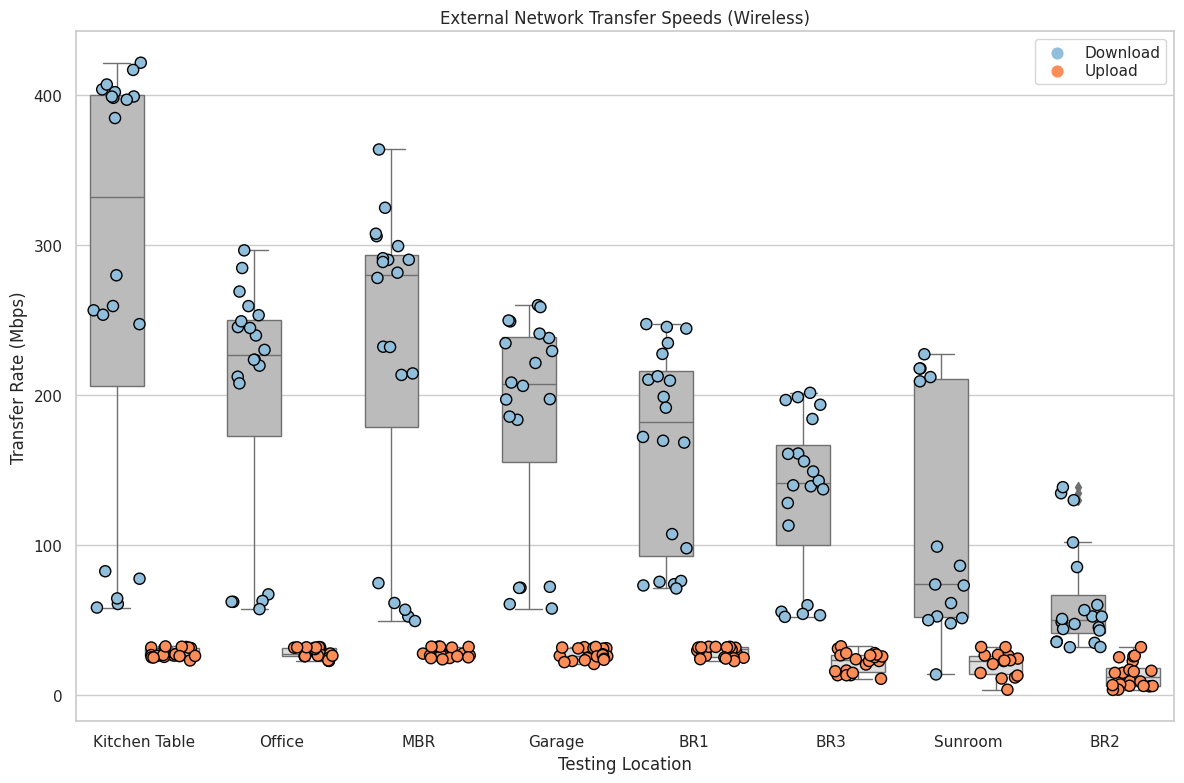

In [94]:
params = dict(data=df3,
              x='location',
              y='speed',
              hue='dir',
              dodge=True)
p = sns.stripplot(size=8,
                  jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  linewidth=1,
                  **params)
p_box = sns.boxplot(palette=['#BBBBBB','#DDDDDD'],linewidth=1,**params)

p.set(xlabel='Testing Location', ylabel='Transfer Rate (Mbps)', title="External Network Transfer Speeds (Wireless)")
p.set_xticklabels(['Kitchen Table','Office','MBR', 'Garage', 'BR1', 'BR3', 'Sunroom', 'BR2'])
#ax.set(ylim=(920, 940))
handles,labels = p.get_legend_handles_labels()
plt.legend(handles[2:],
           ['Download', 'Upload'],
           frameon=True,
           labelspacing=0.2)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'external_wireless.png')

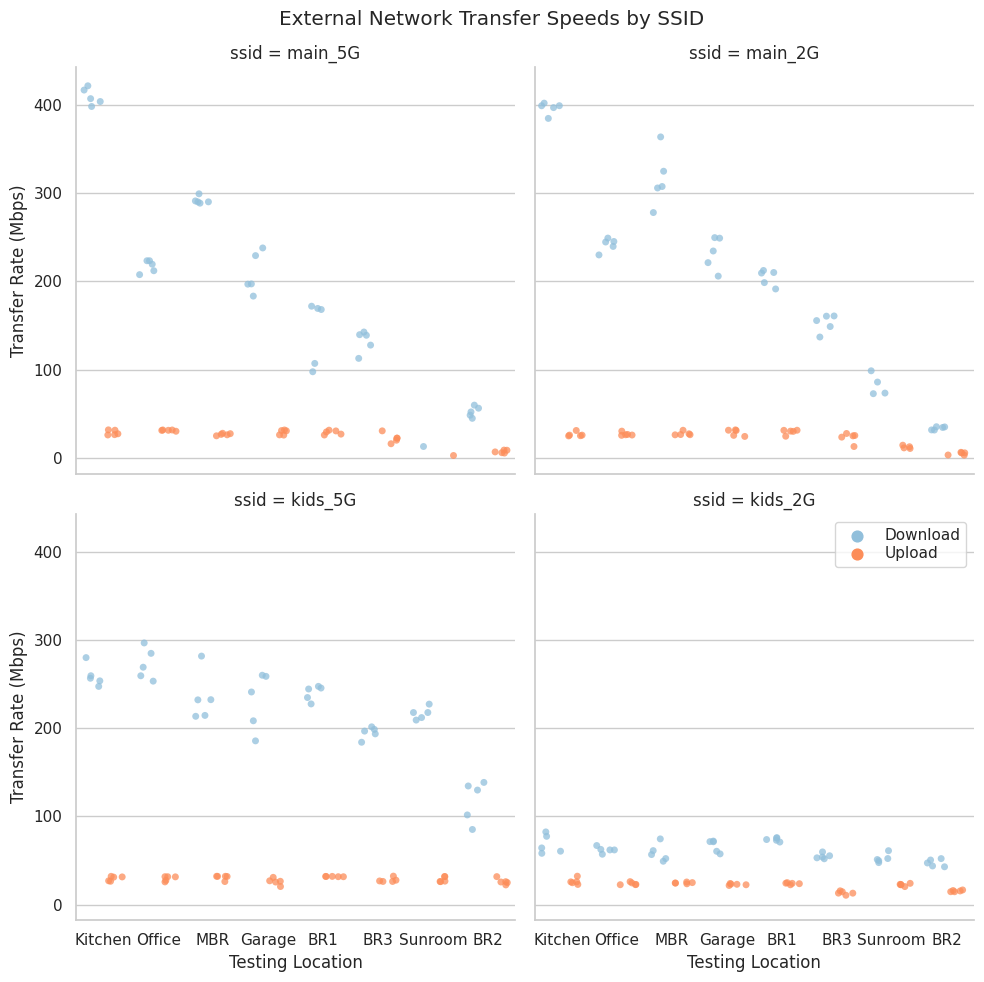

In [95]:
params = dict(data=df3,
              x='location',
              y='speed',
              hue='dir',
              col='ssid',
              col_wrap=2,
              dodge=True)
p = sns.catplot(jitter=0.35,
                palette=['#91bfdb','#fc8d59'],
                edgecolor='black',
                alpha=0.75,
                legend=False,
                **params)
p.set_xticklabels(['Kitchen','Office','MBR', 'Garage', 'BR1', 'BR3', 'Sunroom', 'BR2'])

# steal label info from prior plot?
plt.legend(handles[2:],
           ['Download', 'Upload'],
           frameon=True,
           labelspacing=0.2)

p.fig.suptitle('External Network Transfer Speeds by SSID')
p.set_xlabels('Testing Location')
p.set_ylabels('Transfer Rate (Mbps)')
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'external_wireless_ssid.png')

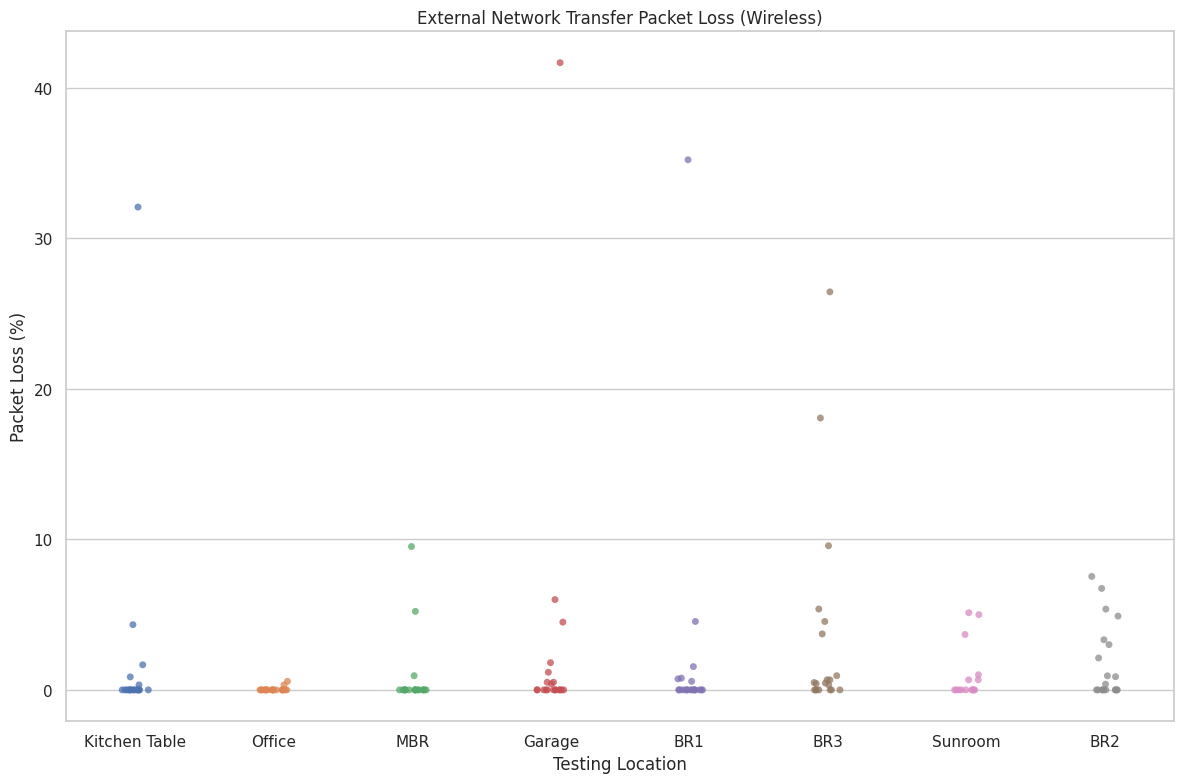

In [96]:
ax = sns.stripplot(y='packetLoss', x='location', 
                   data=df3.where(df3["dir"]=="down"), 
                   jitter=True,
                   marker='o', 
                   alpha=0.75)
# handles,labels = ax.get_legend_handles_labels()
# plt.legend(handles,
#            ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
#            frameon=True,
#            labelspacing=0.2)
ax.set(xlabel='Testing Location', ylabel='Packet Loss (%)', title="External Network Transfer Packet Loss (Wireless)")
ax.set_xticklabels(['Kitchen Table','Office','MBR', 'Garage', 'BR1', 'BR3', 'Sunroom', 'BR2'])
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'external_wireless_rexmit.png')

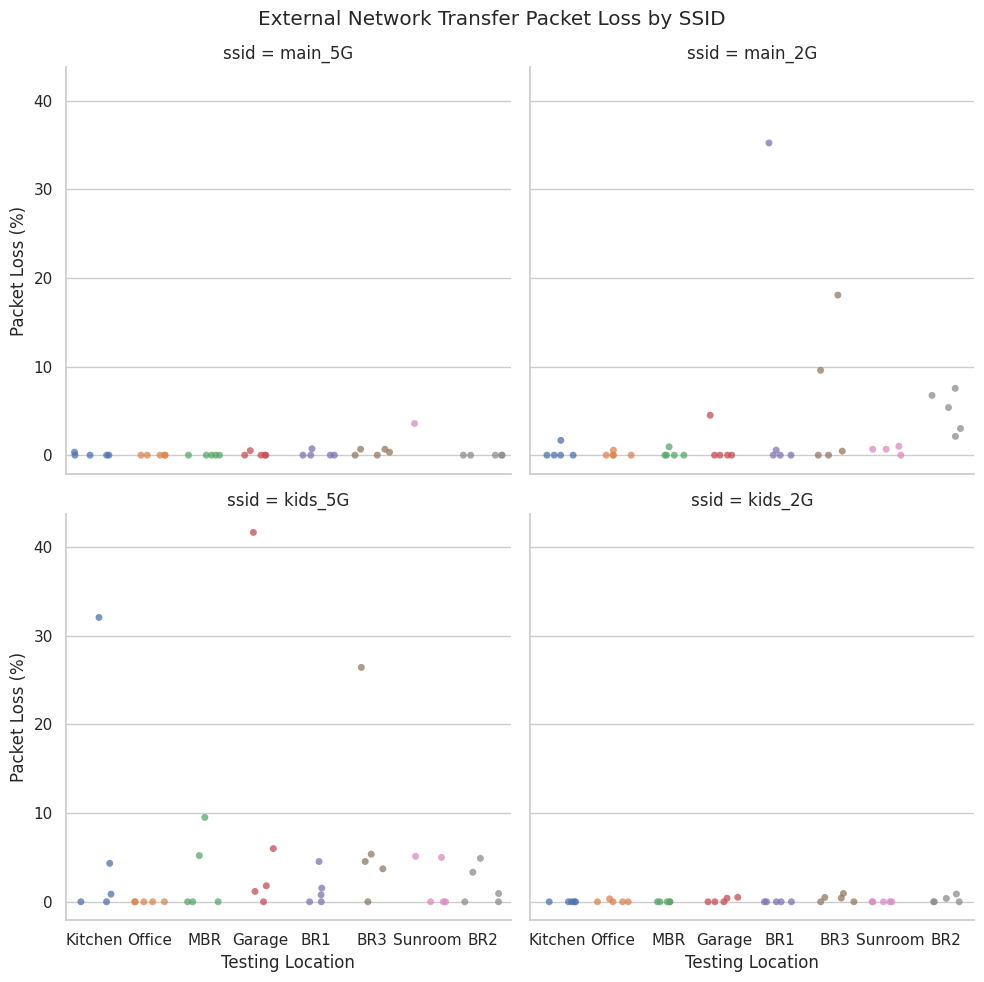

In [97]:
params = dict(data=df3.where(df3["dir"]=="down"),
              x='location',
              y='packetLoss',
              #jitter=0.25,
              col='ssid',
              dodge=False)
p = sns.catplot(jitter=0.35,
                  #palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  #linewidth=1,
                  col_wrap=2,
                   # marker='o',
                legend=False,
                alpha=0.75,
                  **params)
p.set_xticklabels(['Kitchen','Office','MBR', 'Garage', 'BR1', 'BR3', 'Sunroom', 'BR2'])
p.fig.suptitle('External Network Transfer Packet Loss by SSID')
p.set_xlabels('Testing Location')
p.set_ylabels('Packet Loss (%)')
#handles,labels = ax.get_legend_handles_labels()
#plt.legend(handles,
#           ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
#           frameon=True,
#           labelspacing=0.2)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'external_wireless_rexmit_ssid.png')

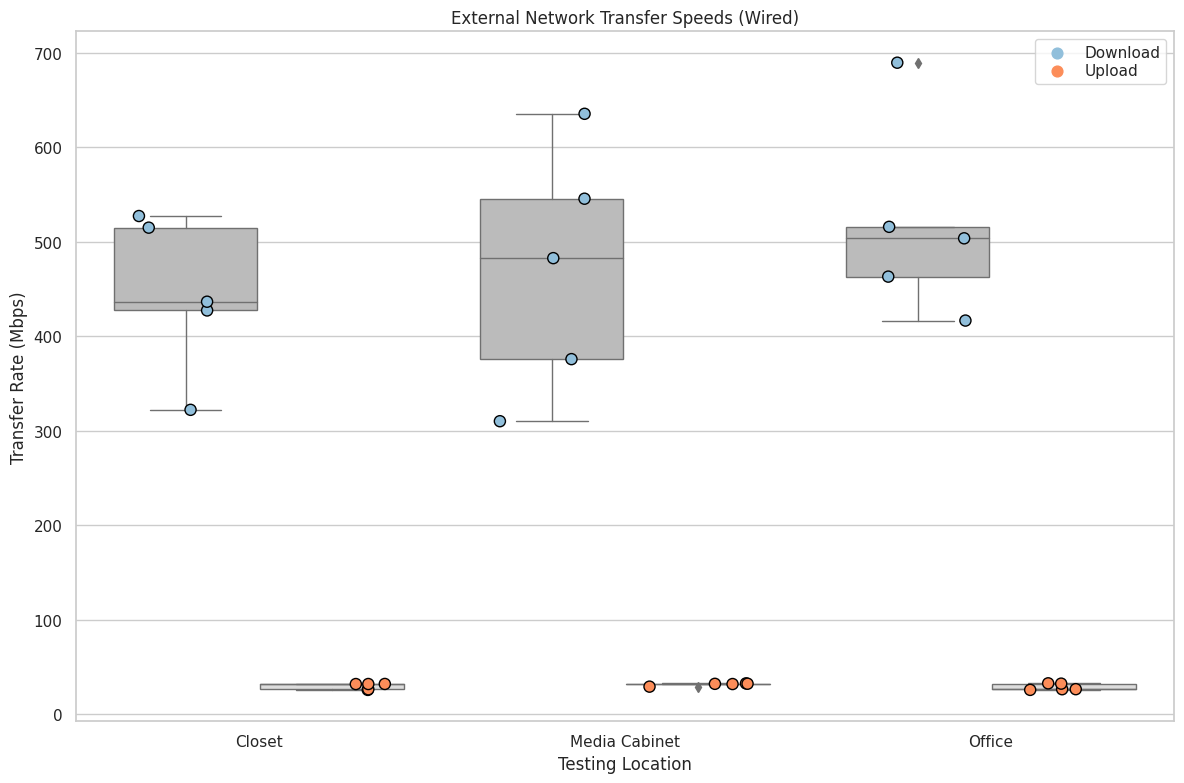

In [98]:
params = dict(data=df4,
              x='location',
              y='speed',
              hue='dir',
              dodge=True)
p = sns.stripplot(size=8,
                  jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  linewidth=1,
                  **params)
p_box = sns.boxplot(palette=['#BBBBBB','#DDDDDD'],linewidth=1,**params)

p.set(xlabel='Testing Location', ylabel='Transfer Rate (Mbps)', title="External Network Transfer Speeds (Wired)")
#p.set_xticklabels(['Kitchen Table','Office','MBR', 'Garage', 'BR1', 'BR3', 'Sunroom', 'BR2'])
p.set_xticklabels(['Closet','Media Cabinet','Office'])
#ax.set(ylim=(920, 940))
handles,labels = p.get_legend_handles_labels()
plt.legend(handles[2:],
           ['Download', 'Upload'],
           frameon=True,
           labelspacing=0.2)
plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'external_wired.png')

In [99]:
# let's get some values
df4.groupby("dir").speed.describe().unstack()

       dir 
count  down     15.000000
       up       15.000000
mean   down    477.606150
       up       29.936676
std    down    103.900570
       up        2.921639
min    down    309.976168
       up       25.682168
25%    down    421.816372
       up       26.408320
50%    down    482.512704
       up       31.864800
75%    down    521.361236
       up       32.155660
max    down    689.315408
       up       32.625672
dtype: float64

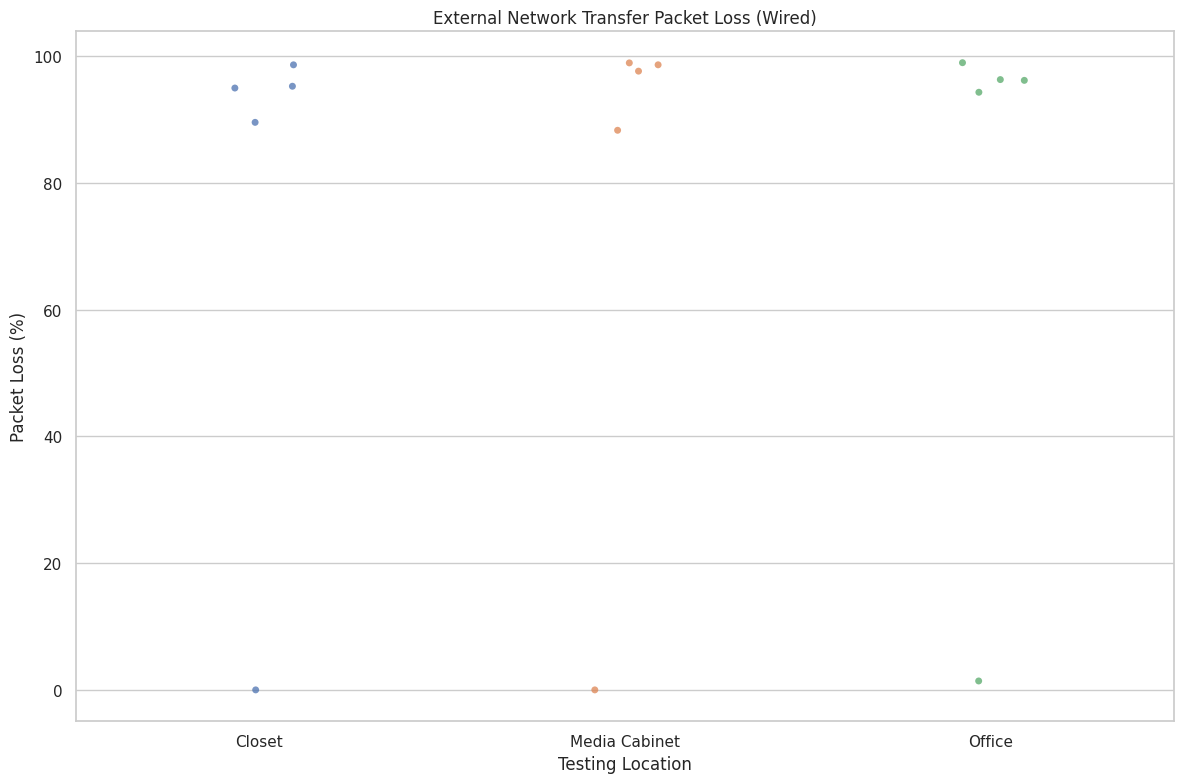

In [100]:
g = sns.stripplot(y='packetLoss', x='location', 
                   data=df4.where(df4["dir"]=="down"), 
                   jitter=True,
                   marker='o', 
                   alpha=0.75)
# handles,labels = ax.get_legend_handles_labels()
# plt.legend(handles,
#            ['Client $\Rightarrow$ Server', 'Server $\Rightarrow$ Client'],
#            frameon=True,
#            labelspacing=0.2)
g.set(xlabel='Testing Location', ylabel='Packet Loss (%)', title="External Network Transfer Packet Loss (Wired)")
g.set_xticklabels(['Closet','Media Cabinet','Office'])

plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'external_wired_rexmit.png')

In [102]:
#df4

In [106]:
dfm2 = df3.append(df4)
dfm2['is_wired'] = np.where(dfm2['ssid']== 'wired', True, False)
# let's get some values
dfm2.groupby(["is_wired", 'dir']).speed.describe().unstack()

count              mean                    std            \
dir        down     up       down         up        down        up   
is_wired                                                             
False     155.0  155.0  172.66287  24.314502  105.663443  7.289809   
True       15.0   15.0  477.60615  29.936676  103.900570  2.921639   

                 min                    25%                    50%             \
dir             down         up        down         up        down         up   
is_wired                                                                        
False      13.460104   3.130744   65.555036  22.624704  185.561832  25.936656   
True      309.976168  25.682168  421.816372  26.408320  482.512704  31.864800   

                 75%                   max             
dir             down        up        down         up  
is_wired                                               
False     245.055544  30.63934  421.844144  32.224680  
True      521.361236  32.15566  689.315408  32.625672

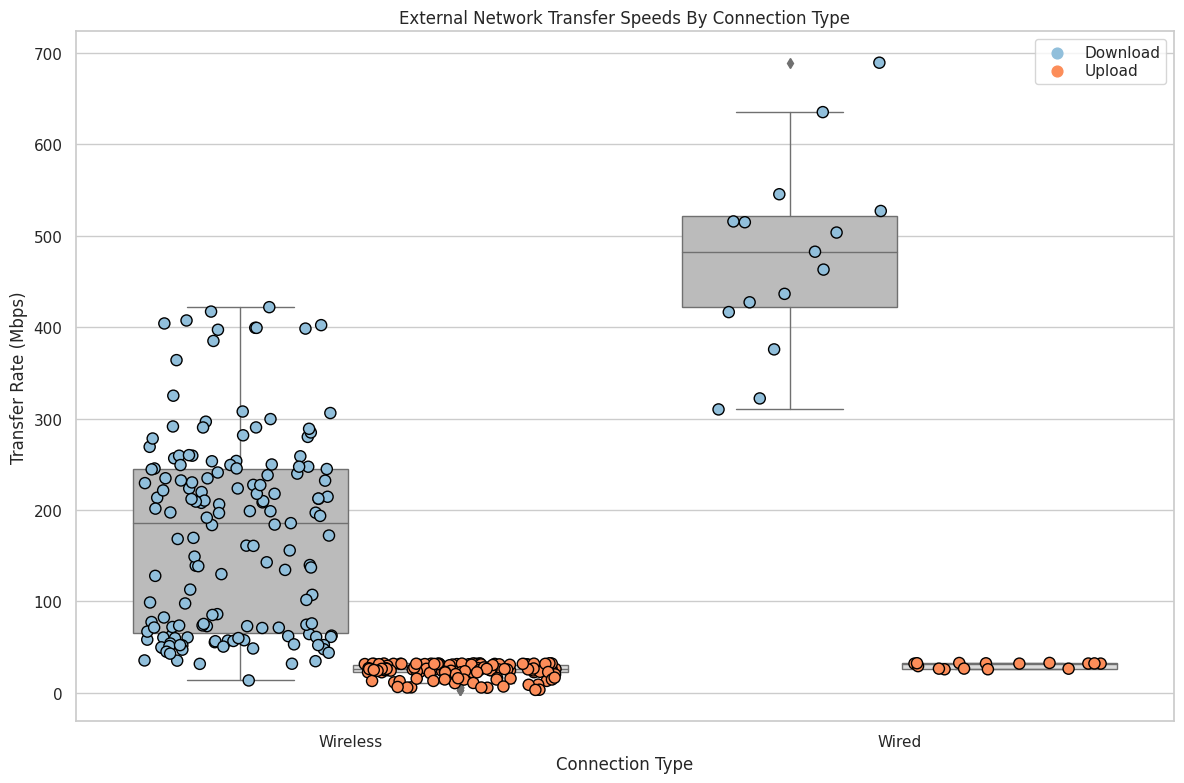

In [110]:
params = dict(data=dfm2,
              x='is_wired',
              y='speed',
              hue='dir',
              dodge=True)
p = sns.stripplot(size=8,
                  jitter=0.35,
                  palette=['#91bfdb','#fc8d59'],
                  edgecolor='black',
                  linewidth=1,
                  **params)
p_box = sns.boxplot(palette=['#BBBBBB','#DDDDDD'],linewidth=1,**params)

p.set(xlabel='Connection Type', ylabel='Transfer Rate (Mbps)', title="External Network Transfer Speeds By Connection Type")
p.set_xticklabels(['Wireless','Wired'])
handles,labels = p.get_legend_handles_labels()
plt.legend(handles[2:],
           ['Download', 'Upload'],
           frameon=True,
           labelspacing=0.2)

plt.tight_layout()
plt.savefig(RESULTS_ROOT + 'external_wired_vs_wireless.png')